## Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

##Import R libraries we'll use.

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr) ;library(dplyr)
library(RColorBrewer)
library(stats)
library(ape)
library(stringr)
library(ade4)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [5]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS" & !(is.na(physeq.Bulk.m$Soil_Moisture)),
                                 physeq.Bulk)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    
physeq.Bulk.core = prune_samples((physeq.Bulk.m$Soil_Moisture != 50),
                                 physeq.Bulk.core)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    

physeq.Bulk.core = physeq.Bulk.core %>% transform_sample_counts(function(x) x/sum(x))

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

#print(physeq.Bulk.Sparsity)
print(physeq.Bulk.core)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 157 samples ]
sample_data() Sample Data:       [ 157 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]




### Calculate Unifrac distances between samples.

In [6]:
%%R
method = 'bray'

In [7]:
%%R
registerDoParallel(cores=20)
wunif.dist.nopas = phyloseq::distance(physeq.Bulk.core, 
                      method = method)

In [8]:
%%R
physeq.Bulk.core


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 157 samples ]
sample_data() Sample Data:       [ 157 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


## Bray Curtis vs. Soil Moisture

In [9]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
head(df)

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744


In [10]:
%%R
SD = physeq.Bulk.core %>% sample_data
dist.Moist = dist(SD$Soil_Moisture)

In [11]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
df.T = melt(as.matrix(dist.Moist, varnames = c('T1', 'T2')))
df.T$moistdist = df.T$value
df.T$T1 = df$T1
df.T$T2 = df$T2
df.T$value = NULL
df.T$Var1 = NULL
df.T$Var2 = NULL

print(head(df))
print(head(df.T))

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744
  moistdist             T1          T2
1 0.0000000    April.NTR.4 April.NTR.4
2 1.1333333 Aug.NTR.3.2015 April.NTR.4
3 1.2000000    April.PTR.3 April.NTR.4
4 0.7666667   July15.NTH.3 April.NTR.4
5 3.7333333      Nov.NTR.1 April.NTR.4
6 2.1666667     June.NTH.2 April.NTR.4


In [12]:
%%R
df.tot = left_join(df, df.T)
tail(df.tot)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("T1", "T2")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


                   T1              T2  value  moistdist
24644 Sept.PTR.1.2015 Sept.NTH.1.2015 0.9015 2.13333333
24645  Aug.PTH.3.2015 Sept.NTH.1.2015 0.8151 1.83333333
24646  Aug.PTH.4.2015 Sept.NTH.1.2015 0.8358 0.06666667
24647 Sept.NTR.2.2015 Sept.NTH.1.2015 0.9138 4.36666666
24648  Aug.PTH.2.2015 Sept.NTH.1.2015 0.7622 1.73333333
24649 Sept.NTH.1.2015 Sept.NTH.1.2015 0.0000 0.00000000


In [13]:
%%R
head(df.tot, n = 20)
df.tot.sep = df.tot %>% tidyr::separate(T1, c("Month_T1", "Treatment_T1", "Rep_T1"))
df.tot.sep = df.tot.sep %>% tidyr::separate(T2, c("Month_T2", "Treatment_T2", "Rep_T2"))

head(df.tot.sep)

  Month_T1 Treatment_T1 Rep_T1 Month_T2 Treatment_T2 Rep_T2     value moistdist
1    April          NTR      4    April          NTR      4 0.0000000 0.0000000
2      Aug          NTR      3    April          NTR      4 0.4997069 1.1333333
3    April          PTR      3    April          NTR      4 0.6171277 1.2000000
4   July15          NTH      3    April          NTR      4 0.5200756 0.7666667
5      Nov          NTR      1    April          NTR      4 0.7084343 3.7333333
6     June          NTH      2    April          NTR      4 0.5763744 2.1666667


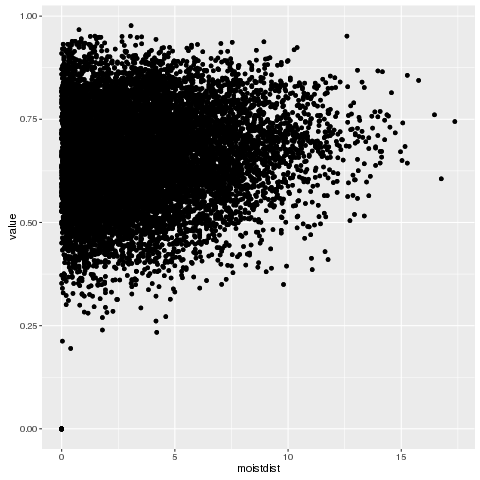

In [14]:
%%R
ggplot(data = df.tot, aes(x = moistdist, y = value)) + geom_point()

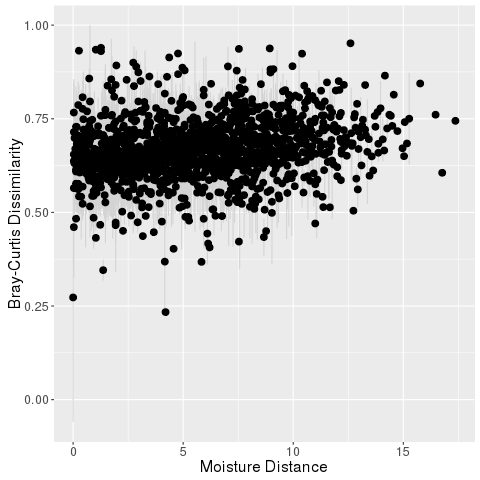

In [15]:
%%R

mean.tempdist = df.tot %>% group_by(moistdist) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)

p = ggplot(data = mean.tempdist, aes(moistdist, meanval)) + geom_errorbar(limits, color = 'light grey')+ 
        geom_point(size = 3) +
    xlab('Moisture Distance') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [16]:
%%R
ggsave(filename = "data/figs/BCvsMoisture.png", plot = p, width =8, height =6)

In [17]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ dist.Moist, nperm = 10000)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ecodist’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:vegan’:

    mantel


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phyloseq’:

    distance


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.1246168  0.0017000  0.9984000  0.0018000  0.1006969  0.1494032 


## Split into Treatment

In [42]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$OM %>% unique
u.lm

[1] R H
Levels: H R


In [43]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, OM == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "R"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 79 samples ]
sample_data() Sample Data:       [ 79 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "H"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 78 samples ]
sample_data() Sample Data:       [ 78 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [44]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

In [45]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, OM == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [46]:
%%R
#treatments = c('NTR','PTR', 'NTH', 'PTH')
treatments = c('R', 'H')
str(treatments)

 chr [1:2] "R" "H"


In [47]:
%%R

join_temp = function(treatment, dist.mat, metadata, moistdata){
    
    m = data.frame(metadata[[treatment]])
    dist = dist.mat[[treatment]]
    moist = filter(moistdata, OM == treatment)
    
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    
    #Creating temperature distance matrix
    moistdata = dist(moist$Soil_Moisture)
    df.T = melt(as.matrix(moistdata, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Treatment = treatment

  
    return(df.tot)
    
    
}


temp.data = lapply(treatments, join_temp, metadata = physeq.Treat.meta, 
                   dist.mat = MH.dist.treat.l,moistdata = SD)

In [48]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_temp = function(treatment, moistdata){
        
    moist = filter(moistdata, OM == treatment)
    moistdata = dist(moist$Soil_Moisture)
    
    return(moistdata)

    
    
}


temp.dist = lapply(treatments, join_temp, moistdata = SD)

In [49]:
%%R

plot_by_treatment = function(df.tempdist) {
    
   treatment = unique(df.tempdist$Treatment)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
   mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Moisture difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(temp.data, plot_by_treatment)

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]


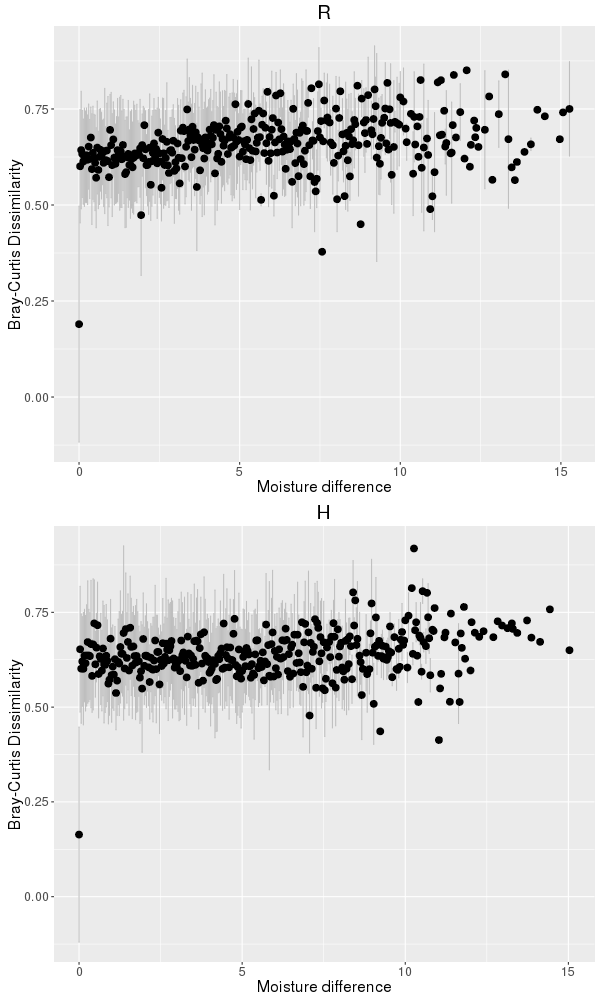

In [50]:
%%R -w 600 -h 1000
p = do.call(grid.arrange, c(plots,list(ncol=1)))
p

In [27]:
%%R
ggsave(filename = "data/figs/BCvsMoisture_HvR.png", plot = p, width =8, height =10)

In [28]:
%%R
mantel.Temp = function(treatment, df.temp, df.dist) {
    
    df.t = df.temp[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(c(1,2), df.temp = temp.dist, df.dist = MH.dist.treat.l, mantel.Temp)

In [29]:
%%R
head(m.temp)

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.1657344  0.0046000  0.9955000  0.0047000  0.1296638  0.2030882 

[[2]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.07802668 0.09590000 0.90420000 0.16890000 0.04614752 0.12047795 



### Testing homogeneity of slopes for biomass management

In [51]:
%%R
T.data = do.call(rbind, temp.data)
head(T.data)

              T1          T2     value tempdist Treatment
1    April.NTR.4 April.NTR.4 0.0000000 0.000000         R
2 Aug.NTR.3.2015 April.NTR.4 0.4997069 1.133333         R
3    April.PTR.3 April.NTR.4 0.6171277 1.200000         R
4      Nov.NTR.1 April.NTR.4 0.7084343 3.733333         R
5     June.PTR.3 April.NTR.4 0.6371159 1.166667         R
6    April.NTR.3 April.NTR.4 0.4553828 0.200000         R


In [52]:
%%R
corr = aov(value~tempdist*Treatment, data=T.data)
summary(corr)

                      Df Sum Sq Mean Sq F value   Pr(>F)    
tempdist               1   7.75   7.746  412.94  < 2e-16 ***
Treatment              1   1.07   1.069   56.99 4.68e-14 ***
tempdist:Treatment     1   0.28   0.283   15.07 0.000104 ***
Residuals          12321 231.12   0.019                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [53]:
%%R
corr2 = aov(value~tempdist+Treatment, data=T.data)
summary(corr2)

               Df Sum Sq Mean Sq F value   Pr(>F)    
tempdist        1   7.75   7.746  412.46  < 2e-16 ***
Treatment       1   1.07   1.069   56.93 4.84e-14 ***
Residuals   12322 231.41   0.019                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [54]:
%%R
anova(corr,corr2)

Analysis of Variance Table

Model 1: value ~ tempdist * Treatment
Model 2: value ~ tempdist + Treatment
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1  12321 231.12                                  
2  12322 231.41 -1  -0.28266 15.068 0.0001042 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Separation by Replicate - temp vs phylogenetic distance

In [30]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Replicate %>% unique
u.lm

[1] 4 3 1 2


In [31]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "4"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [32]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [33]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [34]:
%%R
replicates = c(4, 3, 1, 2)
str(replicates)

 num [1:4] 4 3 1 2


In [35]:
%%R

join_temp = function(replicate, dist.mat, moistdata){
    
    dist = dist.mat[[as.character(replicate)]]
    moist = filter(moistdata, Replicate == replicate)
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))  
    #Creating moisture distance matrix
    moist2 = dist(moist$Soil_Moisture)
    df.T = melt(as.matrix(moist2, varnames = c('T1', 'T2')))
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Replicate = replicate

  
    return(df.tot)
    
    
}


temp.data = lapply(replicates, join_temp, 
                   dist.mat = MH.dist.rep.l, moistdata = SD)

In [36]:
%%R
str(temp.data)

List of 4
 $ :'data.frame':	1521 obs. of  5 variables:
  ..$ T1       : Factor w/ 39 levels "April.NTR.4",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 39 levels "April.NTR.4",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:1521] 0 0.653 0.675 0.619 0.579 ...
  ..$ tempdist : num [1:1521] 0 5.533 8.7 1.667 0.867 ...
  ..$ Replicate: num [1:1521] 4 4 4 4 4 4 4 4 4 4 ...
 $ :'data.frame':	1600 obs. of  5 variables:
  ..$ T1       : Factor w/ 40 levels "Aug.NTR.3.2015",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 40 levels "Aug.NTR.3.2015",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:1600] 0 0.656 0.484 0.584 0.722 ...
  ..$ tempdist : num [1:1600] 0 0.0667 1.9 2.5 2.3 ...
  ..$ Replicate: num [1:1600] 3 3 3 3 3 3 3 3 3 3 ...
 $ :'data.frame':	1521 obs. of  5 variables:
  ..$ T1       : Factor w/ 39 levels "Nov.NTR.1","Nov.NTH.1.2015",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 39 levels "Nov.NTR.1","Nov.NTH.1.2015",..: 1 1 1 1 1 1 1 1 1 1 ...
 

In [37]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_rep = function(physeq.meta){
        
    moistdata = dist(physeq.meta$Soil_Moisture)
    
    return(moistdata)

    
    
}


temp.dist = lapply(physeq.Rep.meta, join_rep)

In [38]:
%%R

plot_by_replicate = function(df.tempdist) {
    
    replicate = unique(df.tempdist$Replicate)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
    mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

    p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Moisture difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(temp.data, plot_by_replicate)

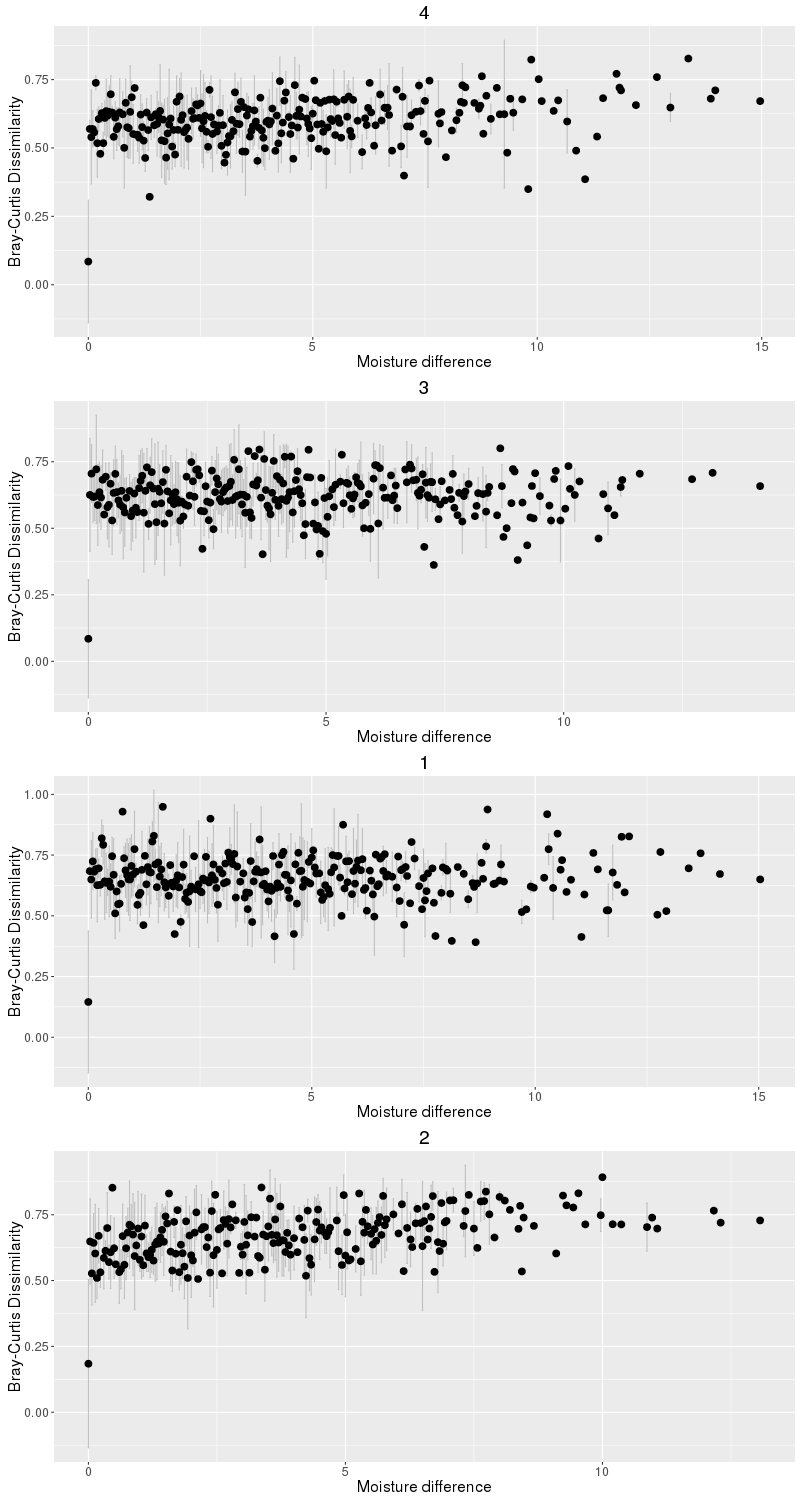

In [39]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [40]:
%%R
mantel.Temp = function(replicate, df.temp, df.dist) {
    
    df.t = df.temp[[as.character(replicate)]]
    df.d = df.dist[[as.character(replicate)]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(replicates, df.temp = temp.dist, df.dist = MH.dist.rep.l, mantel.Temp)

In [41]:
%%R
#Results - replicates 4, 3, 1, 2
m.temp

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.13206392 0.06000000 0.94010000 0.07320000 0.06059588 0.19528513 

[[2]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
 0.007117969  0.438000000  0.562100000  0.920600000 -0.036188270  0.060055168 

[[3]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.01732735  0.55220000  0.44790000  0.82140000 -0.06450236  0.02456398 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.2495749  0.0038000  0.9963000  0.0038000  0.1876584  0.3193154 

